In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

RAW_DIR = Path("../data/raw")
PROCESSED_DIR = Path("../data/processed")

# Load genotypes (index = cultivar IDs)
X = pd.read_csv(RAW_DIR / "genotypes.csv", index_col=0)

# Load phenotypes_clean robustly
ph = pd.read_csv(PROCESSED_DIR / "phenotypes_clean.csv")
print("phenotypes_clean columns:", ph.columns.tolist())

# Case 1: cultivar column exists
if "cultivar" in ph.columns:
    pheno = ph.set_index("cultivar")

# Case 2: cultivar was saved as an unnamed index column
else:
    # common names when an index gets saved to CSV
    possible_index_cols = ["Unnamed: 0", "index"]
    found = [c for c in possible_index_cols if c in ph.columns]
    if not found:
        raise ValueError(
            "Could not find cultivar column. "
            "Expected 'cultivar' OR an index column like 'Unnamed: 0'/'index'. "
            f"Got columns: {ph.columns.tolist()}"
        )
    pheno = ph.set_index(found[0])
    pheno.index.name = "cultivar"

# Validate required fields
required = {"trait_y", "pop"}
missing_req = required - set(pheno.columns)
if missing_req:
    raise ValueError(f"phenotypes_clean is missing required columns: {missing_req}")

# Align phenotype to genotype
missing_cultivars = X.index.difference(pheno.index)
if len(missing_cultivars) > 0:
    raise ValueError(
        f"{len(missing_cultivars)} cultivars in genotypes missing in phenotypes. "
        f"Example: {missing_cultivars[:5].tolist()}"
    )

pheno = pheno.loc[X.index]
y = pheno["trait_y"]
groups = pheno["pop"]

print("X shape:", X.shape)
print("Aligned y shape:", y.shape)
print("Groups:", groups.nunique())


phenotypes_clean columns: ['index', 'trait_y', 'pop']
X shape: (300, 39000)
Aligned y shape: (300,)
Groups: 3


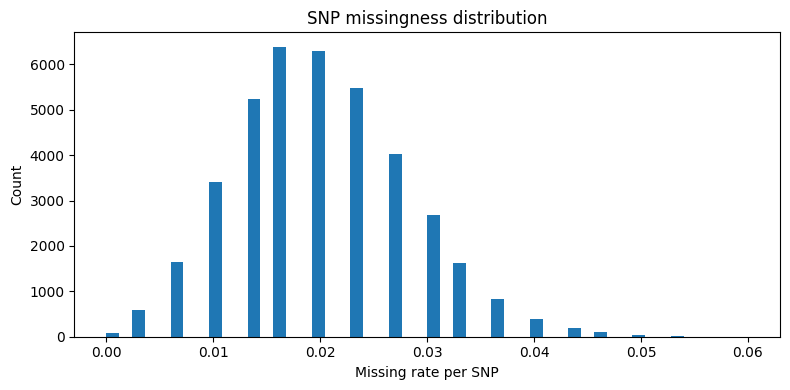

count    39000.000000
mean         0.019987
std          0.008055
min          0.000000
25%          0.013333
50%          0.020000
75%          0.026667
max          0.060000
dtype: float64

In [2]:
missing_rate = X.isna().mean()

plt.figure(figsize=(8,4))
plt.hist(missing_rate, bins=50)
plt.xlabel("Missing rate per SNP")
plt.ylabel("Count")
plt.title("SNP missingness distribution")
plt.tight_layout()
plt.show()

missing_rate.describe()

In [3]:
miss_threshold = 0.10  # remove SNPs with >10% missing
keep_miss = missing_rate <= miss_threshold

X_miss = X.loc[:, keep_miss]

print("Before:", X.shape)
print("After missingness filter:", X_miss.shape)


Before: (300, 39000)
After missingness filter: (300, 39000)


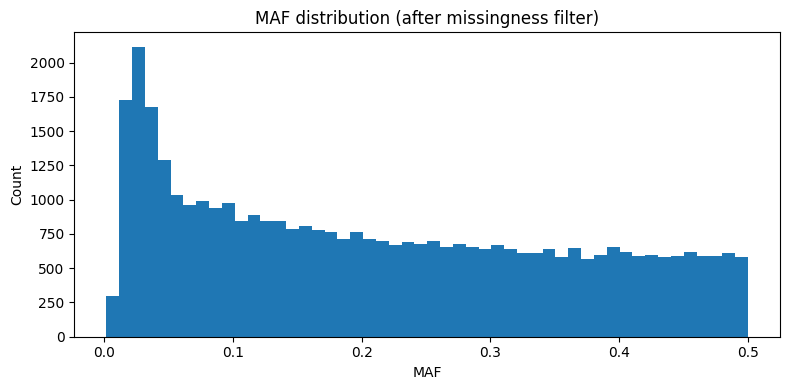

count    39000.000000
mean         0.213860
std          0.147606
min          0.001695
25%          0.077966
50%          0.193878
75%          0.338983
max          0.500000
dtype: float64

In [4]:
# allele frequency approx (dosage mean / 2)
p = X_miss.mean(skipna=True) / 2
maf = p.where(p <= 0.5, 1 - p)

plt.figure(figsize=(8,4))
plt.hist(maf, bins=50)
plt.xlabel("MAF")
plt.ylabel("Count")
plt.title("MAF distribution (after missingness filter)")
plt.tight_layout()
plt.show()

maf.describe()


In [5]:
maf_threshold = 0.02  # reasonable for n=300
keep_maf = maf >= maf_threshold

X_qc = X_miss.loc[:, keep_maf]

print("After MAF filter:", X_qc.shape)


After MAF filter: (300, 37363)


In [6]:
imputer = SimpleImputer(strategy="mean")

X_imp = pd.DataFrame(
    imputer.fit_transform(X_qc),
    index=X_qc.index,
    columns=X_qc.columns
)

print("Missing after imputation:", int(X_imp.isna().sum().sum()))
X_imp.shape


Missing after imputation: 0


(300, 37363)

In [7]:
scaler = StandardScaler()

X_std = pd.DataFrame(
    scaler.fit_transform(X_imp),
    index=X_imp.index,
    columns=X_imp.columns
)

print("Mean abs(mean):", float(np.abs(X_std.mean()).mean()))
print("Mean std:", float(X_std.std().mean()))
X_std.shape



Mean abs(mean): 6.774959726478183e-17
Mean std: 1.0016708449412668


(300, 37363)

In [8]:
pca = PCA(n_components=5)
PCs = pca.fit_transform(X_std)

explained = pca.explained_variance_ratio_
explained



array([0.03304037, 0.0309483 , 0.00355984, 0.00354799, 0.0035204 ])

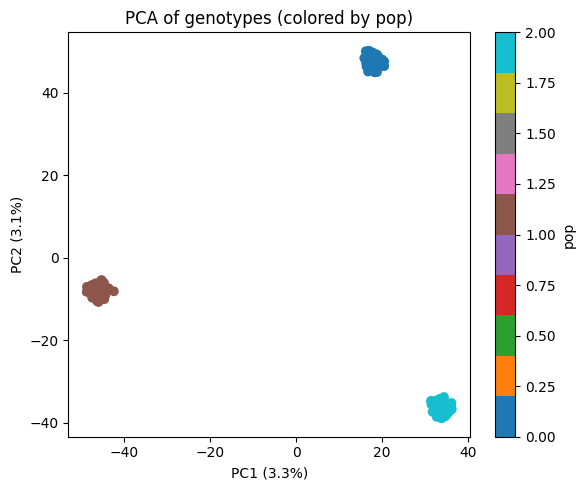

In [9]:
plt.figure(figsize=(6,5))
sc = plt.scatter(PCs[:,0], PCs[:,1], c=groups, cmap="tab10")
plt.xlabel(f"PC1 ({explained[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({explained[1]*100:.1f}%)")
plt.title("PCA of genotypes (colored by pop)")
plt.colorbar(sc, label="pop")
plt.tight_layout()
plt.show()

In [10]:
PROCESSED_DIR = Path("../data/processed")
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

out_path = PROCESSED_DIR / "genotypes_qc_std.csv"
X_std.to_csv(out_path)

print("Saved:", out_path)
print("Final matrix:", X_std.shape)

Saved: ../data/processed/genotypes_qc_std.csv
Final matrix: (300, 37363)


In [11]:
qc_summary = pd.DataFrame([{
    "n_lines": X.shape[0],
    "n_snps_raw": X.shape[1],
    "miss_threshold": miss_threshold,
    "maf_threshold": maf_threshold,
    "n_snps_after_missing": X_miss.shape[1],
    "n_snps_after_maf": X_qc.shape[1],
    "missing_total_raw": int(X.isna().sum().sum()),
    "missing_total_after_qc": int(X_qc.isna().sum().sum()),
    "pc1_var": explained[0],
    "pc2_var": explained[1],
}])

qc_summary

,n_lines,n_snps_raw,miss_threshold,maf_threshold,n_snps_after_missing,n_snps_after_maf,missing_total_raw,missing_total_after_qc,pc1_var,pc2_var
0,300,39000,0.1,0.02,39000,37363,233843,223998,0.03304,0.030948
